**After this laboratory you should be able to**
- Explain how to train GNN's


# Prediction heads

**Node level tasks**  
We have the embeddings, we can predict using the embeddings. Just add a head that maps from the final node embedding dimension to the number of classes / regression targets.  
After that we can compute the loss between the predicted and real targets. 

**Exmaple**  
We can use a *softmax* function with the computed predictions to classify a node.


**Edge level tasks**  
Here we need to make predictions using **pairs** of node embeddings $(h_u, h_v)$. We have multiple options:
1. Concatenate embeddings + linear predictor (like in GAT)
2. Dot product between embeddings
    - $\hat{y}_{uv} = h_u^Th_v$ -- here $\hat{y}_{uv}$ is a single number => we can do a binary prediction
    - $\hat{y}^{(1)}_{uv} = h_u^TW^{(1)}h_v \ \dots \ \hat{y}^{(k)}_{uv} = h_u^TW^{(k)}h_v$ -- We can use a weight matrix $W$  / class for a k-class prediction. After that we concatenate the final results

**Graph level tasks**  
We want to predcit using all the node embeddings from a graph. Therefore, want to *aggregate* the embeddings of the nodes in some way. Again, there are multiple options. 
1. Global mean pooling -- Used when number of nodes  doesn't matter as much. 
2. Global max pooling
3. Global sum pooling -- Used when the structure of the graph matters more.

**Problem with pooling**  
Large graphs might use too much information (especially prevalent in large graphs). Solution: [Hierarchical Graph Representation Learning with
Differentiable Pooling](https://arxiv.org/pdf/1806.08804.pdf) (photo from here)

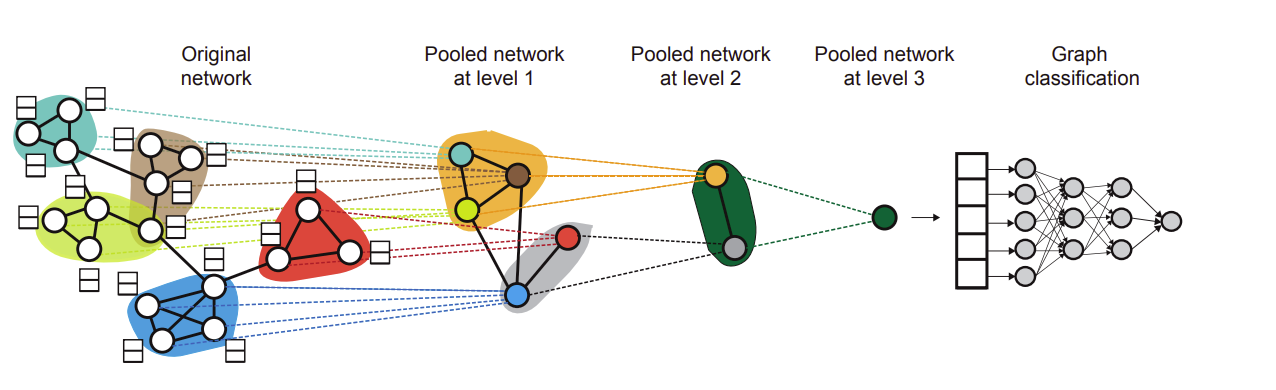

# Train splits

## Training, validation, test

We want to find a model that trains on our data and makes predictions. We want to evaluate this model too. Therefore, we willsplit our dataset into a **training, validation and testing** dataset.

**What is evaluation?**
- Looking at how the model performs based on different *metrics*
    - Ex: Accuracy, confusion matrices etc
    
**Training dataset**
- The model will be trained on this dataset. 
- We can evaluate the model on this dataset in order to see if it **learns something**

**Validation dataset**
- The model will **not** be trained on this dataset. 
- We will evaluate the model on this dataset in order to see if it **generalizes** to samples it hasn't seen before
- After evaluation we will fine tune by hand our model (change some hyperparameters)
    - Human input

**Testing dataset**
- The model will **not** be trained on this dataset. 
- We will evaluate the model on this dataset in order to see how it would perform **in the wild**. (real world)
- This is the final challenge
    - No human input

https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets

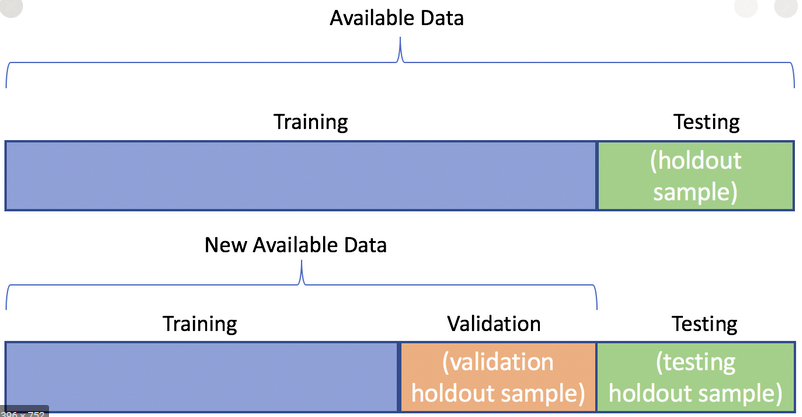

**Careful about**
- Data representativeness $\to$ the data splits should have the same proportions of classes. 
    - Ex: If trainset has 60% class 1 and 40% class 2 then the  validation set shouldn't have 20% class 1 and 80% class 2
- Time: Careful if you split by time
- Duplicate data

## K-fold

To remove the random bias from a single split we might wanna run more experiments where we shuffle the training and validation split multiple times and at the end we average the results.

*When?*
- Little data available
- $+$ Better evaluation
- $-$ Expensive

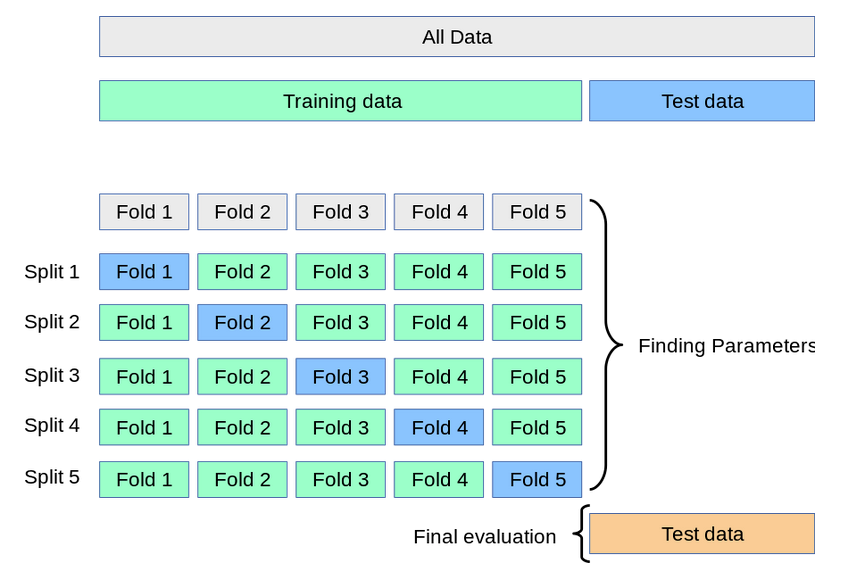

## Problems and solutions 

**Information leakage**  
In simple datasets (like images, tabular data) splitting is easy because each instance is independent from each other. In graphs this is not true because nodes are linked and when we do message aggregation we might collect data from nodes in the validation / test set which we are not supposed to. 

Example: if we compute the embedding of node 1 (train dataset) we collect information from node 5 (test dataset) => node 5 will influence the prediction on node 1

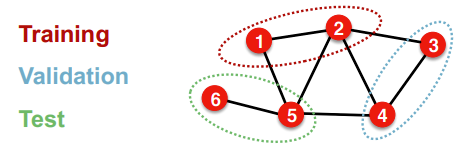


### Node classification

**Transductive setting**  
Like above, the entire graph is used in all dataset splits, we split only the labels into train, validation and test.

**Problem**
- Information leakage

**Inductive setting**  
We disconnect the graph into multiple graphs -- Train graph, validation graph, test graph. In this case there is no information leakage because we don't use information from our validation / test datasets

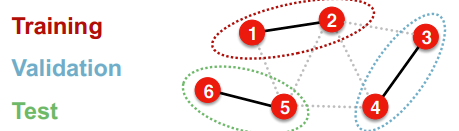

**Problem**
- We throw away edges, for small graphs this might be hurt the performance

### Graph classification

Here each graphs is independent. We split normally into training, validation and test datasets.

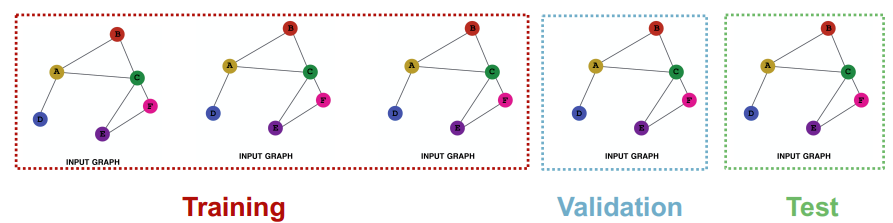

### Edge prediction

We need to create the splits on our own. We start with the graph and we have to hide some edges and try to predict if they will appear.

We have to split the graph into 2 types of edges
1. *Message passing edges* -- Used for GNN message passing
2. *Supervision edges* -- Used for training the network ( compute loss, performance etc)

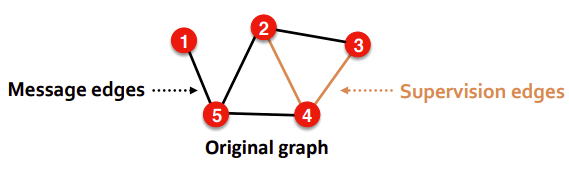


**Transductive setting**  
Take the original graph and set which edges are for messsage edges, supervision edges, validation edges and test edges.
- When training use only message edges to predict supervision edges
- When validating use message edges and supervision edges to predict  validation edges
- When testing use message edges, supervision edges and validation edges to predict test edges

*Intuition*: Graph evolving over time by adding edges

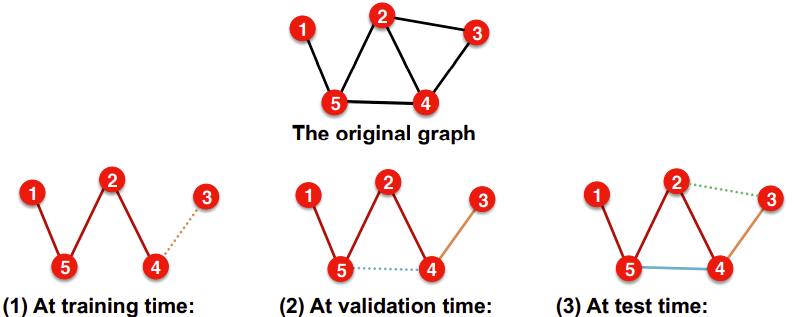


# DeepSnap

[docs](https://snap.stanford.edu/deepsnap/)

In [73]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import os, sys
from copy import deepcopy
import torch

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, from_networkx
import deepsnap

## `Graph` class

In [74]:
from deepsnap.graph import Graph

In [32]:
#?Graph

In [9]:
# From NetworX

G = nx.complete_graph(100)
H = Graph(G)
print(H)

Graph(G=[], edge_index=[2, 9900], edge_label_index=[2, 9900], node_label_index=[100])


g:\conda3\envs\pytorch_env\lib\site-packages\deepsnap\graph.py:522: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")


In [28]:
## Adding node features

G = nx.Graph()
G.add_node(0, node_feature=torch.tensor([1,2,3]))
G.add_node(1, node_feature=torch.tensor([4,5,6]))
G.add_edge(0, 1)
H = Graph(G)
print(H.node_feature)

tensor([[1, 2, 3],
        [4, 5, 6]])


In [15]:
# From dataset

pyg_dataset = Planetoid(root = os.path.join('..', 'data', 'tmp', 'Cora'), name = 'Cora')
graph = Graph.pyg_to_graph(pyg_dataset[0])
print(graph)

Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708])


In [26]:
# Deepsnap creates indexes for slicing when splitting
print(graph.node_label_index)
print(graph.edge_label_index)

tensor([   0,    1,    2,  ..., 2705, 2706, 2707])
tensor([[   0,    0,    0,  ..., 2688, 2695, 2707],
        [ 633, 1862, 2582,  ..., 2687, 2694, 2706]])


## Data and Dataset

The `deepsnap.dataset.GraphDataset` class holds and manipulates a set of DeepSNAP graphs used for training, validation and / or testing. 

We can specify the task using the `task` parameter:
- `"node"`: Node classification.
- `"edge"`: Edge classification.
- `"link_pred"`: Link prediction.
- `"graph"`: Graph classification.



In [75]:
from deepsnap.dataset import GraphDataset

In [35]:
#?GraphDataset

### Graph classification task

In [37]:
from torch_geometric.datasets import TUDataset

pyg_dataset = TUDataset(root = os.path.join('..', 'data', 'tmp', 'enzymes'), name='ENZYMES')

# Transforms a torch_geometric dataset into a list of deepsnap Graphs
graphs = GraphDataset.pyg_to_graphs(pyg_dataset) 

In [41]:
# Transform the list of traphs into a GraphDataset with a specified task
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print(dataset)

GraphDataset(600)


In [54]:
#?dataset.split

In [51]:
dataset.split(transductive = False, split_ratio = [.6, .2, .2])

[GraphDataset(360), GraphDataset(120), GraphDataset(120)]

### Node classification task

In [83]:
G = nx.karate_club_graph()
nx.set_node_attributes(G, {k: 0 if n['club'] == 'Mr. Hi' else 1 for k, n in G.nodes.items()}, name="node_label")

In [84]:
color_dict = {k: list(matplotlib.colors.BASE_COLORS.keys())[v] for k, v in nx.get_node_attributes(G, "node_label").items()}

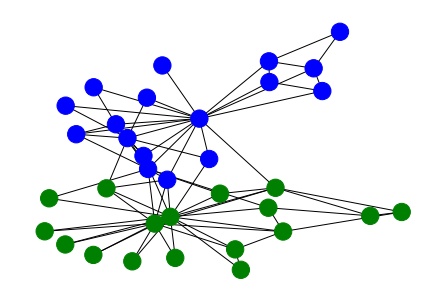

In [85]:
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos = pos, node_color = list(color_dict.values()))

In [38]:
dataset = GraphDataset([G], task="node")
dataset.graphs

[Graph(G=[], club=[34], edge_index=[2, 156], edge_label_index=[2, 156], name=[], node_label=[34], node_label_index=[34], task=[])]

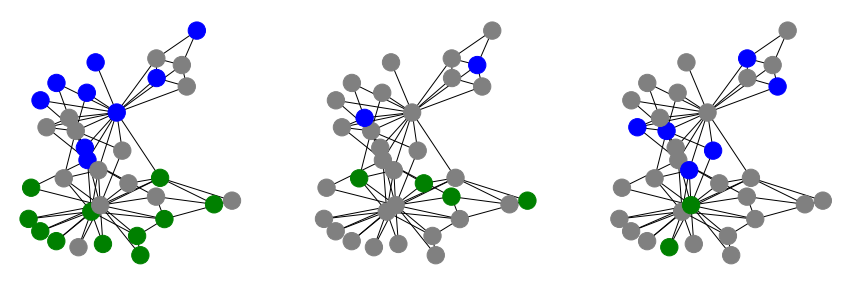

In [39]:
# Color the datasets

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.6, 0.2, 0.2])

plt.figure(figsize = (15, 5))

for i, current_dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    # Make a color map
    node_colors = ['grey'] * G.number_of_nodes()
    for node_idx in current_dataset.graphs[0].node_label_index:
        node_colors[node_idx] = color_dict[node_idx.item()]
    plt.subplot(1, 3, i + 1)
    nx.draw(G, pos = pos, node_color = node_colors)
    

In [12]:
# A bigger split

pyg_dataset = Planetoid(root = os.path.join('..', 'data', 'tmp', 'Cora'), name = 'Cora')
graph = Graph.pyg_to_graph(pyg_dataset[0])
dataset = GraphDataset([graph], task = "node")
print(graph)

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.6, 0.2, 0.2])


Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708], task=[])


In [14]:
dataset_train.graphs

[Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[1624], node_label_index=[1624], task=[])]

### Link prediction task

The indices of the supervision edges are stored in `edge_label_index` and the labels in `edge_labels`. The `edge_label` and `edge_label_index` include negative edges

Parameters to take into account
- `edge_negative_sampling_ratio` -- Since graphs are sparse we usuallty want to sample negative edges. This is the number of negative samples compared to that of positive edges.
- `edge_train_mode` -- in `all` mode training supervision edges are same with the message passing edges. In `disjoint` mode, training supervision objectives are different from the message passing edges.

In [76]:
#?GraphDataset

In [111]:
G = nx.karate_club_graph()
graph = Graph(G)
print(graph)

dataset = GraphDataset([graph], task = "link_pred", edge_train_mode='all')
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.6, 0.2, 0.2])

Graph(G=[], club=[34], edge_index=[2, 156], edge_label_index=[2, 156], name=[], node_label_index=[34])


g:\conda3\envs\pytorch_env\lib\site-packages\deepsnap\graph.py:522: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")


In [112]:
G.number_of_edges()

78

In [113]:
print(dataset_train[0])
print(dataset_val[0])
print(dataset_test[0])

Graph(G=[], club=[34], edge_index=[2, 92], edge_label=[184], edge_label_index=[2, 184], negative_label_val=[1], node_label_index=[34])
Graph(G=[], club=[34], edge_index=[2, 92], edge_label=[60], edge_label_index=[2, 60], negative_label_val=[1], node_label_index=[34])
Graph(G=[], club=[34], edge_index=[2, 122], edge_label=[68], edge_label_index=[2, 68], negative_label_val=[1], node_label_index=[34])


In [114]:
dataset_train[0].edge_label # 1 = Positive edge, 0  = Negative edge

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [115]:
def are_disjoint(edge_index_1, edge_index_2):
    """Checks if 2 edge indexes are disjoint"""
    edge_index_1_np = edge_index_1.T.detach().cpu().numpy()
    edge_index_2_np = edge_index_2.T.detach().cpu().numpy() 
    
    set1 = set(tuple(edge) for edge in edge_index_1_np)
    set2 = set(tuple(edge) for edge in edge_index_2_np)
    return len(set1 & set2) == 0

In [116]:
num_edges = dataset[0].edge_label_index.shape[1] # Does not include negative edges
# The next ones include negative edges
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2


print(f"Number of edges: {num_edges}")
print(f"Number of train edges: {num_train_edges}")
print(f"Number of val edges: {num_val_edges}")
print(f"Number of test edges: {num_test_edges}")
print()


train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]

val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]

test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]

print(are_disjoint(train_pos_edge_index, train_neg_edge_index)) # True
print(are_disjoint(train_pos_edge_index, val_pos_edge_index)) # True 
print(are_disjoint(train_pos_edge_index, test_pos_edge_index)) # True
print(are_disjoint(train_neg_edge_index, test_neg_edge_index)) # Usually False 

Number of edges: 156
Number of train edges: 92
Number of val edges: 30
Number of test edges: 34

True
True
True
False


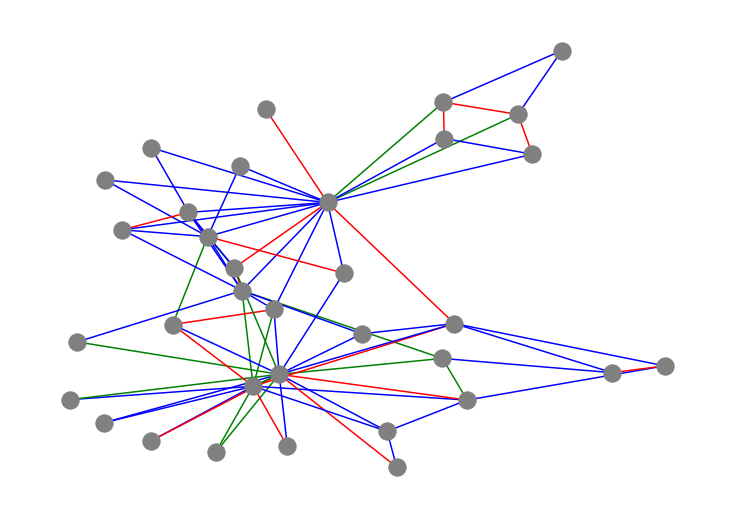

In [121]:
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.6, 0.2, 0.2])

plt.figure(figsize = (10, 7))

edge_colors = {}
for current_dataset, color in zip([dataset_train, dataset_val, dataset_test], ['blue', 'green', 'red']):
    # Iterate through edges and labels
    for edge, label in zip(current_dataset[0].edge_label_index.T, current_dataset[0].edge_label):
        # Check if it's a positive edge
        if edge in edge_colors:
        if label != 0:
            # Add the color
            edge_colors[(edge[0].item(), edge[1].item())]  = color
    

H = deepcopy(G)
nx.classes.function.set_edge_attributes(H, edge_colors, name='color')
colors = list(nx.get_edge_attributes(H, 'color').values())

nx.draw(H, pos = pos, node_color = 'grey', edge_color= colors, width = 1.5)
    

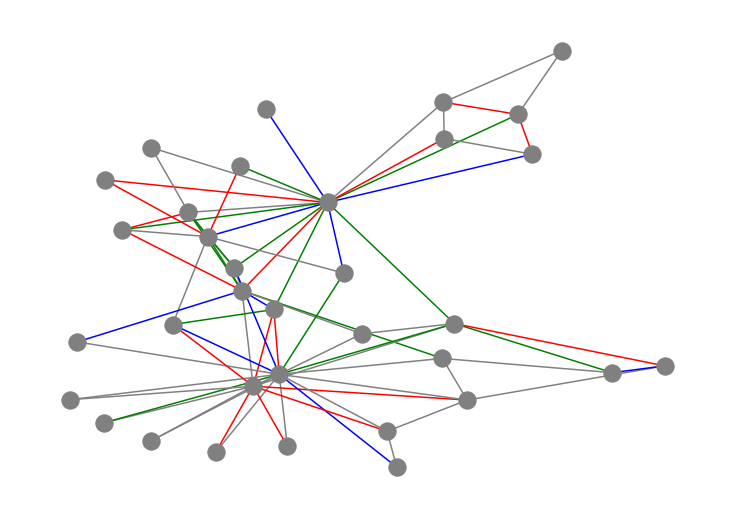

In [128]:
G = nx.karate_club_graph()
graph = Graph(G)
dataset = GraphDataset([graph], task = "link_pred", edge_train_mode='disjoint') # set to disjoint graph
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.6, 0.2, 0.2])

plt.figure(figsize = (10, 7))
edge_colors = {}
for current_dataset, color in zip([dataset_train, dataset_val, dataset_test], ['blue', 'green', 'red']):
    for edge, label in zip(current_dataset[0].edge_label_index.T, current_dataset[0].edge_label):
        if label != 0:
            edge_colors[(edge[0].item(), edge[1].item())]  = color
for edge in G.edges:
    if edge not in edge_colors:
        edge_colors[edge] = "grey"

H = deepcopy(G)
nx.classes.function.set_edge_attributes(H, edge_colors, name='color')
colors = list(nx.get_edge_attributes(H, 'color').values())

nx.draw(H, pos = pos, node_color = 'grey', edge_color= colors, width = 1.5)
    